# NASNet model and transfer learning for CIFAR 10

In [0]:
import os
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from PIL import Image
from keras.datasets import mnist
from keras.models import Sequential
from keras import regularizers
from keras.datasets import cifar10
#from keras.regularizers import WeightRegularizer, ActivityRegularizer 
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization 
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
#from plotter import Plotter
# from keras.utils.visualize_util import plot
import h5py
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense
from keras.models import Sequential
from keras.applications.nasnet import NASNetMobile
from keras.callbacks import EarlyStopping,ModelCheckpoint
from pathlib import Path
import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


In [0]:
def get_annotations_map():
	valAnnotationsPath = 'tiny-imagenet-200/tiny-imagenet-200/val/val_annotations.txt'
	valAnnotationsFile = open(valAnnotationsPath, 'r')
	valAnnotationsContents = valAnnotationsFile.read()
	valAnnotations = {}

	for line in valAnnotationsContents.splitlines():
		pieces = line.strip().split()
		valAnnotations[pieces[0]] = pieces[1]

	return valAnnotations

In [0]:
def load_images(path,num_classes):
    #Load images
    
    print('Loading ' + str(num_classes) + ' classes')

    X_train=np.zeros([num_classes*500,32,32,3],dtype='uint8')
    y_train=np.zeros([num_classes*500], dtype='uint8')

    trainPath=path+'/train'

    print('loading training images...');

    i=0
    j=0
    annotations={}
    for sChild in os.listdir(trainPath):
        sChildPath = os.path.join(os.path.join(trainPath,sChild),'images')
        annotations[sChild]=j
        for c in os.listdir(sChildPath):
            X=np.array(Image.open(os.path.join(sChildPath,c)))
            if len(np.shape(X))==2:
                X_train[i]=np.array([X,X,X])
            else:
                X_train[i]=np.transpose(X,(1,0,2))
            y_train[i]=j
            i+=1
        j+=1
        if (j >= num_classes):
            break

    print('finished loading training images')

    val_annotations_map = get_annotations_map()

    X_test = np.zeros([num_classes*50,32,32,3],dtype='uint8')
    y_test = np.zeros([num_classes*50], dtype='uint8')


    print('loading test images...')

    i = 0
    testPath=path+'/val/images'
    for sChild in os.listdir(testPath):
        if val_annotations_map[sChild] in annotations.keys():
            sChildPath = os.path.join(testPath, sChild)
            X=np.array(Image.open(sChildPath))
            if len(np.shape(X))==2:
                X_test[i]=np.array([X,X,X])
            else:
                X_test[i]=np.transpose(X,(1,0,2))
            y_test[i]=annotations[val_annotations_map[sChild]]
            i+=1
        else:
            pass



    return X_train,y_train,X_test,y_test

In [0]:
from google.colab import files
uploaded=files.upload()


Saving tiny-imagenet-200.zip to tiny-imagenet-200 (1).zip


In [0]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['tiny-imagenet-200.zip']), 'r')
data.extractall()


In [0]:
train_data_dir = 'tiny-imagenet-200/tiny-imagenet-200/train'  
validation_data_dir = 'tiny-imagenet-200/tiny-imagenet-200/val'  
test_data_dir = 'tiny-imagenet-200//tiny-imagenet-200/test' 
target_names = [item for item in os.listdir(train_data_dir) if os.path.isdir(os.path.join(train_data_dir, item))]
nb_train_samples = sum([len(files) for _, _, files in os.walk(train_data_dir)])  
nb_validation_samples = sum([len(files) for _, _, files in os.walk(validation_data_dir)])
nb_test_samples = sum([len(files) for _, _, files in os.walk(test_data_dir)])
total_nb_samples = nb_train_samples + nb_validation_samples + nb_test_samples

nb_classes = len(target_names)      # number of output classes

print('Training a CNN Multi-Classifier Model ......')
print('\n - names of classes: ', target_names, '\n - # of classes: ', nb_classes)
print(' - # of trained samples: ', nb_train_samples, '\n - # of validation samples: ', nb_validation_samples,
      '\n - # of test samples: ', nb_test_samples,
       '\n - total # of samples: ', total_nb_samples, '\n - train ratio:', round(nb_train_samples/total_nb_samples*100, 2),
      '\n - validation ratio:', round(nb_validation_samples/total_nb_samples*100, 2),
      '\n - test ratio:', round(nb_test_samples/total_nb_samples*100, 2),
     ' %', '\n - # of epochs: ', 2, '\n - batch size: ', 500)

Training a CNN Multi-Classifier Model ......

 - names of classes:  ['n02129165', 'n03837869', 'n01742172', 'n03250847', 'n03126707', 'n02815834', 'n04532670', 'n03854065', 'n12267677', 'n07615774', 'n03649909', 'n03584254', 'n02226429', 'n02423022', 'n03014705', 'n09332890', 'n03617480', 'n02206856', 'n03763968', 'n03201208', 'n01774384', 'n01698640', 'n01944390', 'n04507155', 'n04532106', 'n03400231', 'n03796401', 'n04259630', 'n02883205', 'n02403003', 'n03976657', 'n02837789', 'n04251144', 'n02123045', 'n02795169', 'n01855672', 'n02124075', 'n04540053', 'n04067472', 'n04560804', 'n02056570', 'n01983481', 'n02486410', 'n07920052', 'n04074963', 'n04376876', 'n04118538', 'n04465501', 'n03838899', 'n03404251', 'n04597913', 'n02988304', 'n03160309', 'n02504458', 'n04417672', 'n02410509', 'n02909870', 'n06596364', 'n07734744', 'n03983396', 'n02480495', 'n02281406', 'n04371430', 'n03662601', 'n03544143', 'n07875152', 'n03937543', 'n02927161', 'n01644900', 'n07720875', 'n02841315', 'n026994

(32, 32, 3)


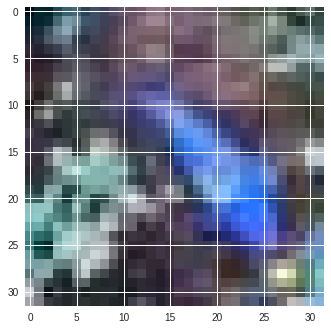

In [0]:
import matplotlib.pylab as plt
img = cv2.imread('tiny-imagenet-200/tiny-imagenet-200/train/n01443537/images/n01443537_9.JPEG')
print(img.shape)
plt.imshow(img)


In [0]:
path='tiny-imagenet-200/tiny-imagenet-200'
X_train,y_train,X_test,y_test=load_images(path,nb_classes)

Loading 200 classes
loading training images...
finished loading training images
loading test images...


In [0]:
model = Sequential()
model.add(NASNetMobile(include_top=False,weights=None,pooling='avg',input_shape=(32,32,3)))
model.add(Dense(200,activation='softmax'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 1056)              4269716   
_________________________________________________________________
dense_2 (Dense)              (None, 200)               211400    
Total params: 4,481,116
Trainable params: 4,444,378
Non-trainable params: 36,738
_________________________________________________________________


In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

y_train = keras.utils.to_categorical(y_train, nb_classes)
y_test = keras.utils.to_categorical(y_test, nb_classes)

In [0]:
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ["accuracy"]
             )

In [0]:
history=model.fit(X_train, y_train,
              batch_size=500,
              epochs=2,
              validation_data=(X_test, y_test),
              shuffle=False)

Instructions for updating:
Use tf.cast instead.
Train on 100000 samples, validate on 10000 samples
Epoch 1/2
100000/100000 [==============================] - 188s 2ms/step - loss: 5.5560 - acc: 0.0000e+00 - val_loss: 16.0257 - val_acc: 0.0051
Epoch 2/2
100000/100000 [==============================] - 105s 1ms/step - loss: 5.3084 - acc: 0.0020 - val_loss: 15.0459 - val_acc: 0.0047


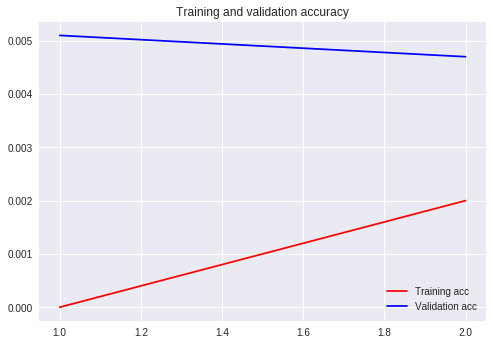

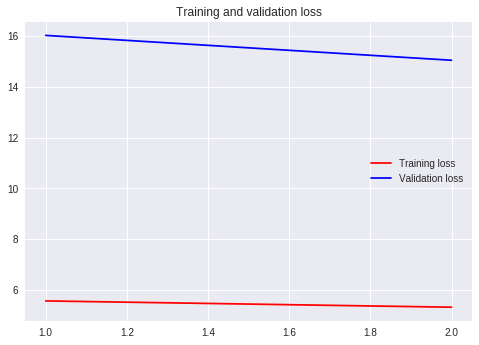

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()


# CIFAR Transfer learning

In [54]:
(XC_train, yC_train), (XC_test, yC_test) = cifar10.load_data()

XC_train = XC_train.astype('float32')
XC_test = XC_test.astype('float32')
XC_train /= 255
XC_test /= 255
print(XC_train.shape[0], 'train samples')
print(XC_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
yC_train = keras.utils.to_categorical(yC_train, 10)
yC_test = keras.utils.to_categorical(yC_test, 10)




50000 train samples
10000 test samples


In [0]:
model = Sequential()
model.add(NASNetMobile(include_top=False,weights=None,pooling='avg',input_shape=(32,32,3)))
model.add(Dense(10,activation='softmax'))


In [36]:
model.summary()

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x7f8702978358>>

In [0]:
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ["accuracy"]
             )


In [38]:
history=model.fit(XC_train, yC_train,
              batch_size=500,
              epochs=2,
              validation_data=(XC_test, yC_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 146s 3ms/step - loss: 1.8292 - acc: 0.3260 - val_loss: 1.9397 - val_acc: 0.3825
Epoch 2/2
50000/50000 [==============================] - 54s 1ms/step - loss: 1.4653 - acc: 0.4685 - val_loss: 2.7912 - val_acc: 0.3271


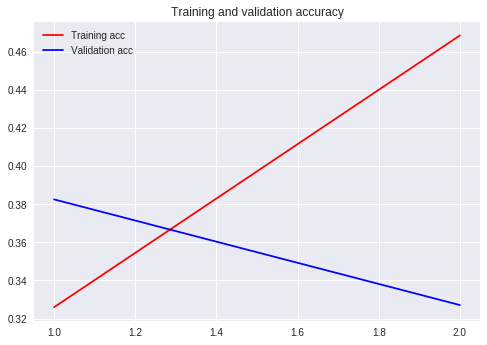

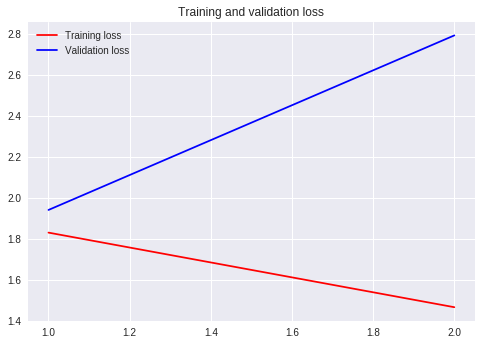

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()


#Fine Tuning

In [51]:
model=Sequential()
model.add(NASNetMobile_conv)
model.add(layers.Dense(10,activation='softmax'))

NameError: ignored

In [57]:
# Freeze the layers except the last 4 layers
NASNetMobile_conv=NASNetMobile(include_top=False,weights=None,pooling='avg',input_shape=(32,32,3))

for layer in NASNetMobile_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in NASNetMobile_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f86765c6860> False
<keras.layers.convolutional.Conv2D object at 0x7f86765c6ba8> False
<keras.layers.normalization.BatchNormalization object at 0x7f86765c6a20> False
<keras.layers.core.Activation object at 0x7f8676579320> False
<keras.layers.convolutional.Conv2D object at 0x7f8676579c50> False
<keras.layers.normalization.BatchNormalization object at 0x7f86765b48d0> False
<keras.layers.core.Activation object at 0x7f8676415e80> False
<keras.layers.core.Activation object at 0x7f86762b76d8> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f8676415f28> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f8676287e48> False
<keras.layers.convolutional.SeparableConv2D object at 0x7f8676415dd8> False
<keras.layers.convolutional.SeparableConv2D object at 0x7f867625bc50> False
<keras.layers.normalization.BatchNormalization object at 0x7f86763b79e8> False
<keras.layers.normalization.BatchNormalization object at 0x7f867617a978> F

In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 1056)              4269716   
_________________________________________________________________
dense_5 (Dense)              (None, 10)                10570     
Total params: 4,280,286
Trainable params: 4,243,548
Non-trainable params: 36,738
_________________________________________________________________


In [60]:
from keras import optimizers
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
history=model.fit(XC_train, yC_train,
              batch_size=500,
              epochs=2,
              validation_data=(XC_test, yC_test),
              shuffle=True)
# Train the model
# Save the model
model.save('small_last4.h5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 356s 7ms/step - loss: 2.0992 - acc: 0.2347 - val_loss: 2.0257 - val_acc: 0.2744
Epoch 2/2
50000/50000 [==============================] - 54s 1ms/step - loss: 1.7905 - acc: 0.3394 - val_loss: 1.8945 - val_acc: 0.3137


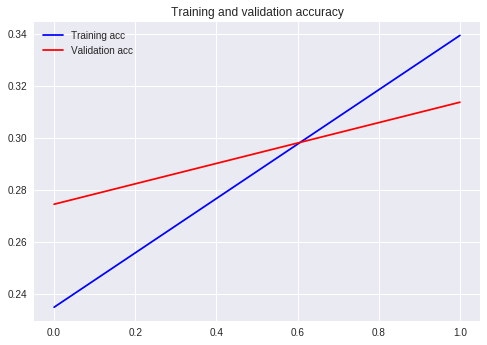

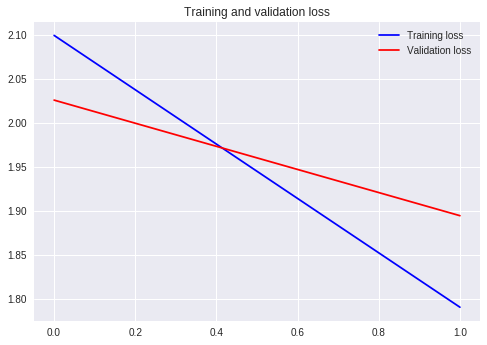

In [61]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()